<a href="https://colab.research.google.com/github/Smarties123/bio-inspired-cwk2-web/blob/main/research/Bio_Inspired_CWK_2_Final_Version_Larger_Images_%26_Colour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bio Inspired CWK 2 Final Version - Larger Images & Colour


## 01 Imports & global config


In [1]:
!pip -q install minisom scikit-image

In [2]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from skimage import io, transform, util
from skimage.metrics import structural_similarity as ssim
from minisom import MiniSom
from collections import defaultdict
import glob

np.random.seed(42)

NOISE_LEVELS   = [0,10,20,30,40,50,60,70,80,90,95]
STEPS_HOPFIELD = 20
STEPS_CA       = 20
EPOCHS_SOM     = 2000
MAX_SIDE       = 64          # resize shorter side to 64 px (≈128² for colour)


## 02 Image Loading and Preprocessing
This section loads grayscale and color images, normalizes them to [0,1], and resizes them to a target dimension for compatibility with the memory models. Images are converted to `(C, H, W)` format and flattened into vectors for processing, supporting both grayscale (single-channel) and color (multi-channel) inputs.


In [3]:
def load_image(path, *, as_gray=False, target_size=None):
    """
    Load an image from disk, convert to float32 in [0,1], and reshape to (C, H, W).

    Args:
        path (str): File path to image.
        as_gray (bool): Load as grayscale if True.
        target_size (int or tuple): Resize so shorter side is target_size, or resize to (h, w).

    Returns:
        np.ndarray: Float32 image array with shape (C, H, W).
    """
    img = io.imread(path, as_gray=as_gray)  # Load image from disk
    img = util.img_as_float32(img) if img.dtype != np.float32 else img  # Normalize to float32 [0,1]

    # Reshape to (C, H, W)
    if img.ndim == 2:
        img = img[np.newaxis, ...]          # Grayscale: add channel dim
    else:
        img = img.transpose(2, 0, 1)        # Color: transpose (H,W,C) to (C,H,W)

    C, H, W = img.shape

    # Resize if target size is provided
    if target_size is not None:
        if isinstance(target_size, int):
            # Maintain aspect ratio: scale so shorter side = target_size
            if H < W:
                h2, w2 = target_size, int(W * target_size / H)
            else:
                h2, w2 = int(H * target_size / W), target_size
        else:
            h2, w2 = target_size  # Direct size (h, w)
        img = transform.resize(img, (C, h2, w2), anti_aliasing=True)

    return img.astype(np.float32)  # Final float image in (C, H, W)


# --- Load and preprocess example images ---
IMAGE_PATHS = {
    'Gray':  glob.glob('gray_folder/*.png'),
    'Color': glob.glob('color_folder/*.jpg'),
}

def load_all_images(paths, *, as_gray, target_size):
    arrs = []
    for p in paths:
        img = load_image(p, as_gray=as_gray, target_size=target_size)
        C, H, W = img.shape
        arrs.append(dict(vec=img.reshape(-1), C=C, H=H, W=W))
    return arrs

patterns: dict[str, list[dict]] = {}
for tag, paths in IMAGE_PATHS.items():
    patterns[tag] = load_all_images(paths,
                                    as_gray=(tag == 'Gray'),
                                    target_size=MAX_SIDE)


In [4]:
import os

# Get all files in the current directory
all_files = os.listdir('/content')

IMAGE_PATHS = {
    'Gray':  sorted([f for f in all_files if f.startswith('gray_') and f.endswith('.png')]),
    'Color': sorted([f for f in all_files if f.startswith('color_') and f.endswith('.jpg')]),
}


## 03 General helpers

In [5]:
def to_pm1(x): return x * 2 - 1
def to_01(x):  return (x + 1) / 2

def add_salt_pepper(x, pct):
    x = x.copy()
    n_flip = int(x.size * pct / 100)
    idx = np.random.choice(x.size, n_flip, replace=False)
    x[idx] = 1 - x[idx]
    return x

def mse_ssim(rec, ref, C, H, W):
    rec = rec.reshape(C,H,W); ref = ref.reshape(C,H,W)
    mse  = np.mean((rec-ref)**2)
    ssim_v = ssim(ref.transpose(1,2,0), rec.transpose(1,2,0),
                  channel_axis=-1, data_range=1)
    return mse, ssim_v


# 04 Models

In [6]:
import numpy as np
from minisom import MiniSom  # make sure minisom is installed

STEPS_HOPFIELD = 5  # tweak as desired
STEPS_CA = 4        # tweak as desired

def to_pm1(x: np.ndarray) -> np.ndarray:
    """Map 0/1 → -1/+1 (float)."""
    return 2.0 * x.astype(float) - 1.0

def to_01(x: np.ndarray) -> np.ndarray:
    """Map -1/+1 → 0/1 (float)."""
    return (x > 0).astype(float)


class HopfieldPseudoInverse:
    """Size‑ and channel‑agnostic Hopfield network using the pseudoinverse rule."""

    def __init__(self, pats01: np.ndarray):
        """
        Parameters
        ----------
        pats01 : ndarray, shape (P, N)
            Training patterns in 0/1 form where *P* is the number of patterns
            and *N* is the flattened dimensionality (H × W × C).
        """
        P_pm1 = to_pm1(pats01).astype(float)  # (P, N)

        # Classic pseudoinverse rule: W = Pᵀ (P Pᵀ)⁻¹ P
        Cmat = P_pm1 @ P_pm1.T               # (P, P)
        W = P_pm1.T @ np.linalg.inv(Cmat) @ P_pm1  # (N, N)

        # Remove self‑connections and scale by N to keep activations bounded
        np.fill_diagonal(W, 0.0)
        self.W = (W / P_pm1.shape[1]).astype(np.float32)

    def recall(self, x01: np.ndarray, *, steps: int = STEPS_HOPFIELD) -> np.ndarray:
        """Asynchronously update the pattern for the given number of *steps*."""
        x = to_pm1(x01).astype(float).copy()
        N = x.size
        for _ in range(steps):
            for i in np.random.permutation(N):
                x[i] = 1.0 if (self.W[i] @ x) >= 0.0 else -1.0
        return to_01(x)


class WeightedMajorityCA:
    """Simple weighted‑majority 3×3 CA applied independently per channel."""

    def __init__(self, kernel: np.ndarray | None = None, thresh: float = 0.5):
        if kernel is None:                   # default Gaussian‑like weights
            kernel = np.array([[1, 2, 1],
                               [2, 4, 2],
                               [1, 2, 1]], float) / 16.0
        self.kernel = kernel.astype(float)
        self.thresh = float(thresh)


    def _step(self, g: np.ndarray) -> np.ndarray:
        """One CA update; *g* shape is (C, H, W)."""
        C, H, W = g.shape
        pad = np.pad(g, ((0, 0), (1, 1), (1, 1)), mode='wrap')

        acc = np.zeros_like(g, dtype=float)
        # Manual 3×3 convolution (broadcast over channels) – still fast for demo sizes.
        for di in range(3):
            for dj in range(3):
                acc += pad[:, di:di + H, dj:dj + W] * self.kernel[di, dj]

        return (acc >= self.thresh).astype(float)


    def recall(self,
               x01: np.ndarray,
               *,
               shape: tuple[int, int, int],  # (C, H, W)
               steps: int = STEPS_CA) -> np.ndarray:
        C, H, W = shape
        g = x01.reshape(shape).astype(float)
        for _ in range(steps):
            g = self._step(g)
        return g.reshape(-1)


class SOMKNN:
    """K‑nearest‑neighbour averaging on top of a Self‑Organising Map."""

    def __init__(self, pats01: np.ndarray, *, m: int = 20, n: int = 20, K: int = 5):
        self.K = int(K)
        self.som = MiniSom(m, n, pats01.shape[1], sigma=4.0, learning_rate=0.5)
        self.som.random_weights_init(pats01)
        self.som.train_random(pats01, 1000, verbose=False)
        self.codes = self.som.get_weights().reshape(-1, pats01.shape[1])  # (m·n, N)

    def recall(self, x01: np.ndarray) -> np.ndarray:
        dists = np.linalg.norm(self.codes - x01, axis=1)
        idx = np.argsort(dists)[: self.K]
        return self.codes[idx].mean(axis=0)


# class HybridHopCaHop:
#     """Pipeline: Hopfield‑PI → CA → Hopfield‑PI (size aware)."""

#     def __init__(self,
#                  hop: HopfieldPseudoInverse,
#                  ca: WeightedMajorityCA,
#                  *,
#                  shape: tuple[int, int, int]):  # (C, H, W)
#         self.hop = hop
#         self.ca = ca
#         self.shape = shape

#     def recall(self, x01: np.ndarray) -> np.ndarray:
#         h1 = self.hop.recall(x01)                       # stage 1
#         ca_out = self.ca.recall(h1, shape=self.shape)   # stage 2
#         return self.hop.recall(ca_out)                  # stage 3


# --- Enhanced Hybrid Hopfield–CA Model ---
class LAMEnhanced:
    def __init__(self, hop, ca, h_steps=5, c_steps=10, w=0.5, cycles=2):
        # Set up modules and parameters: hopfield/CA step counts, blend weight, cycles
        self.hop, self.ca = hop, ca
        self.hs, self.cs = h_steps, c_steps
        self.w, self.cy = w, cycles

    def recall(self, x01):
        # Alternate between global and local recall, blending after each cycle
        cur = x01.copy()
        for _ in range(self.cy):
            h = self.hop.recall(cur)              # partial Hopfield reconstruction
            c = self.ca.recall(h)                 # local CA smoothing
            cur = (1 - self.w) * h + self.w * c   # blend both outputs
        return cur




class CAWrapper:
    """Wrap WeightedMajorityCA to store (C,H,W) so .recall(x) works."""
    def __init__(self, ca: WeightedMajorityCA, shape: tuple[int, int, int], steps: int = STEPS_CA):
        self.ca = ca
        self.shape = shape
        self.steps = steps

    def recall(self, x01: np.ndarray) -> np.ndarray:
        return self.ca.recall(x01, shape=self.shape, steps=self.steps)

def build_zoo(patterns: dict[str, list[dict]]) -> dict[str, dict]:
    zoo: dict[str, dict] = {}
    for tag, pats in patterns.items():
        # Stack all flattened vectors into a (P, N) array
        vecs = np.stack([p['vec'] for p in pats])  # shape (P, N)
        C, H, W = pats[0]['C'], pats[0]['H'], pats[0]['W']
        shape = (C, H, W)

        # Train models on all patterns
        hop_pi = HopfieldPseudoInverse(vecs)
        ca_wt = CAWrapper(WeightedMajorityCA(), shape)
        som_kn = SOMKNN(vecs, K=5)

        # New LAM-Enhanced model
        lam = LAMEnhanced(
            hop=hop_pi,
            ca=ca_wt,
            h_steps=STEPS_HOPFIELD,
            c_steps=STEPS_CA,
            w=0.5,
            cycles=2
        )

        zoo[tag] = {
            'Hopfield-PI': hop_pi,
            'CA-Weighted': ca_wt,
            'SOM-KNN': som_kn,
            'LAM-Enhanced': lam,
        }

    return zoo

# Rebuild your models
improved_zoo = build_zoo(patterns)

In [ ]:
import time

improved_zoo = {}

for tag, pattern_list in patterns.items():
    for i, p in enumerate(pattern_list):
        try:
            vec, C, H, W = p['vec'], p['C'], p['H'], p['W']
            shape = (C, H, W)

            print(f"\n🔧 Building models for {tag}_{i}...")

            # Hopfield-PI
            t0 = time.time()
            hop_pi = HopfieldPseudoInverse(np.stack([vec]))
            t1 = time.time()
            print(f"  ✅ Hopfield-PI built in {t1 - t0:.2f} s")

            # CA (lightweight, no training)
            t0 = time.time()
            ca_wt = WeightedMajorityCA()
            ca_wrap = CAWrapper(ca_wt, shape)
            t1 = time.time()
            print(f"  ✅ CA-Weighted wrapper ready in {t1 - t0:.2f} s")

            # SOM-KNN
            t0 = time.time()
            som_kn = SOMKNN(np.stack([vec]), K=5)
            t1 = time.time()
            print(f"  ✅ SOM-KNN built in {t1 - t0:.2f} s")

            # LAM-Enhanced
            t0 = time.time()
            lam = LAMEnhanced(hop=hop_pi, ca=ca_wrap, h_steps=5, c_steps=4, w=0.5, cycles=2)
            t1 = time.time()
            print(f"  ✅ LAM-Enhanced assembled in {t1 - t0:.2f} s")

            # Save all models
            improved_zoo[f'{tag}_{i}'] = {
                'Hopfield-PI': hop_pi,
                'CA-Weighted': ca_wt,
                'SOM-KNN':     som_kn,
                'LAM-Enhanced': lam
            }

        except Exception as e:
            print(f"❌ Failed to build {tag}_{i}: {e}")



🔧 Building models for Gray_0...
  ✅ Hopfield-PI built in 0.20 s
  ✅ CA-Weighted wrapper ready in 0.00 s
  ✅ SOM-KNN built in 35.35 s
  ✅ LAM-Enhanced assembled in 0.00 s

🔧 Building models for Gray_1...
  ✅ Hopfield-PI built in 0.13 s
  ✅ CA-Weighted wrapper ready in 0.00 s
  ✅ SOM-KNN built in 31.22 s
  ✅ LAM-Enhanced assembled in 0.00 s

🔧 Building models for Gray_2...
  ✅ Hopfield-PI built in 0.13 s
  ✅ CA-Weighted wrapper ready in 0.00 s
  ✅ SOM-KNN built in 33.00 s
  ✅ LAM-Enhanced assembled in 0.00 s

🔧 Building models for Gray_3...
  ✅ Hopfield-PI built in 0.13 s
  ✅ CA-Weighted wrapper ready in 0.00 s
  ✅ SOM-KNN built in 30.63 s
  ✅ LAM-Enhanced assembled in 0.00 s

🔧 Building models for Gray_4...
  ✅ Hopfield-PI built in 0.20 s
  ✅ CA-Weighted wrapper ready in 0.00 s
  ✅ SOM-KNN built in 32.07 s
  ✅ LAM-Enhanced assembled in 0.00 s

🔧 Building models for Color_0...
  ✅ Hopfield-PI built in 1.54 s
  ✅ CA-Weighted wrapper ready in 0.00 s
  ✅ SOM-KNN built in 95.90 s
  ✅ LAM-En

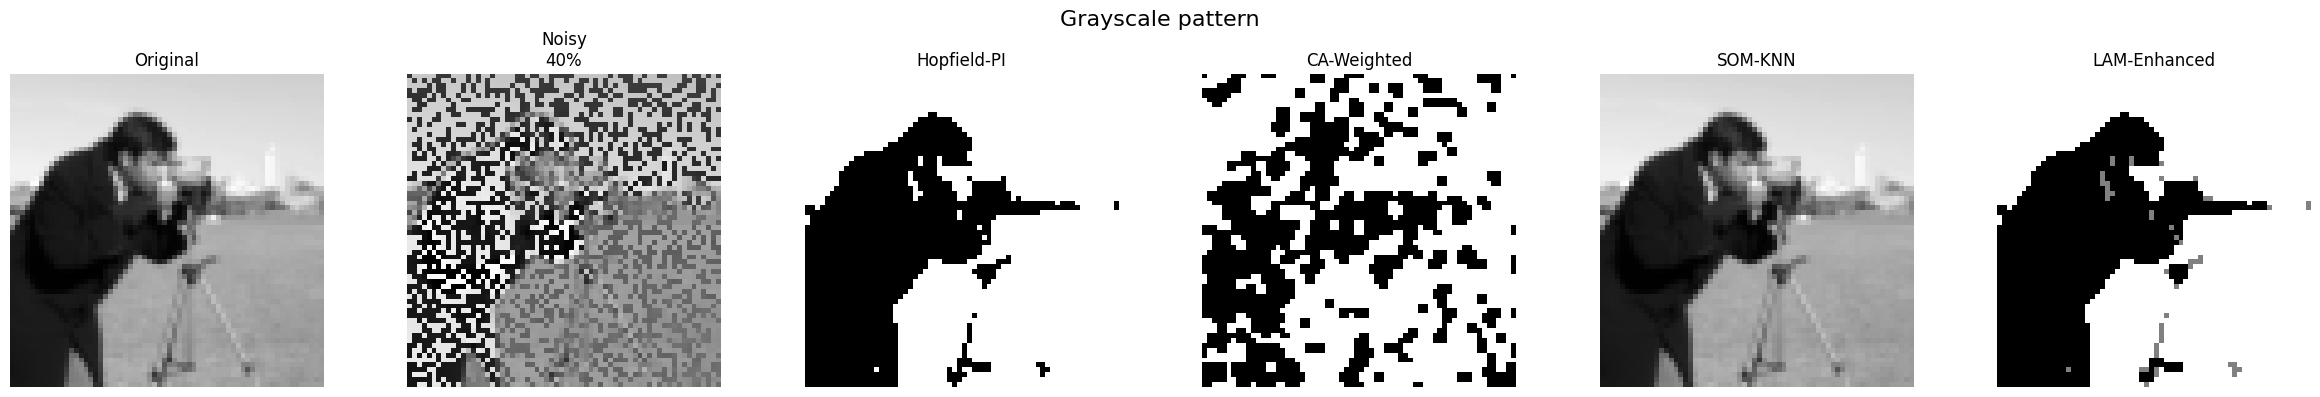

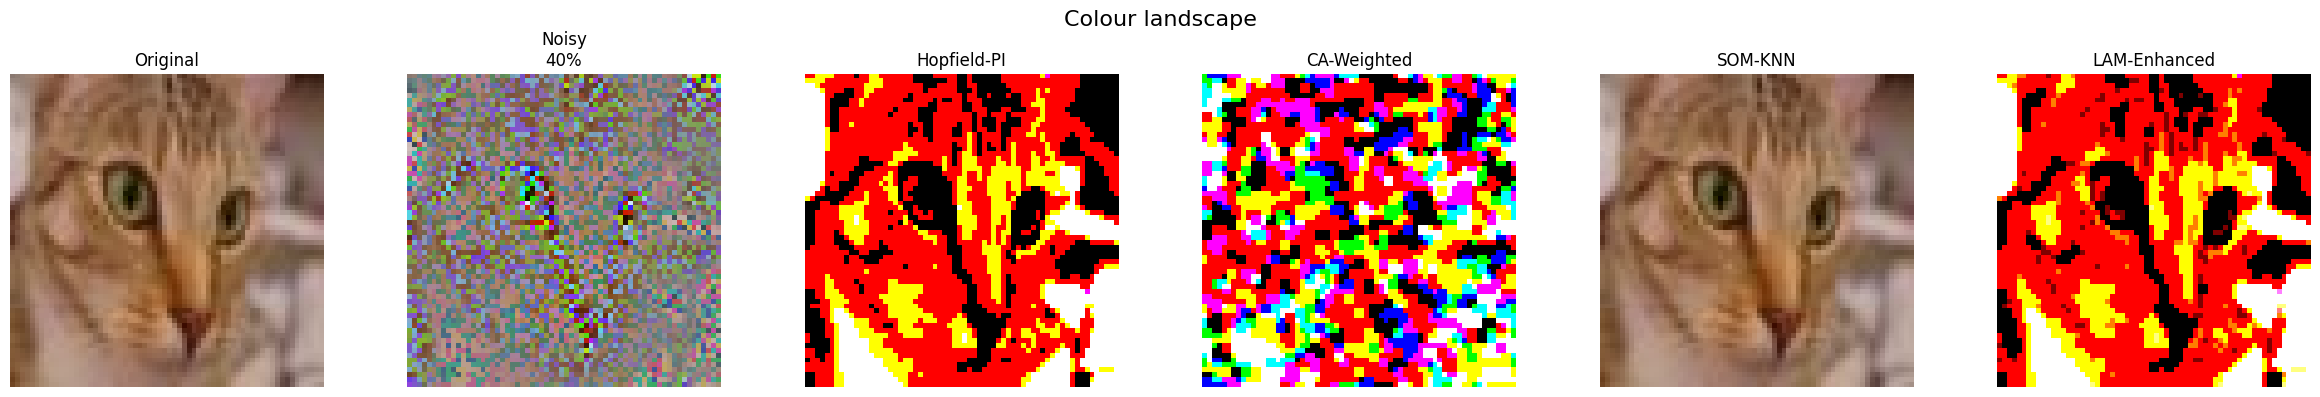

In [ ]:
def show_suite(title, pat, models, noise_pct=30):
    vec,C,H,W = pat['vec'], pat['C'], pat['H'], pat['W']
    noisy = add_salt_pepper(vec, noise_pct)
    fig, ax = plt.subplots(1, len(models)+2, figsize=(4*(len(models)+2), 4))

    def imshow(v, a):
        a.imshow(v.reshape(C,H,W).transpose(1,2,0),
                cmap='gray' if C==1 else None)
        a.axis('off')

    # original + noisy
    imshow(vec,   ax[0]); ax[0].set_title('Original')
    imshow(noisy, ax[1]); ax[1].set_title(f'Noisy\n{noise_pct}%')

    # reconstructions
    for i, (lab, m) in enumerate(models.items(), 2):
        if isinstance(m, WeightedMajorityCA):
            rec = m.recall(noisy, shape=(C,H,W))
        else:
            rec = m.recall(noisy)
        imshow(rec, ax[i]); ax[i].set_title(lab)

    fig.suptitle(title, fontsize=16); plt.tight_layout(); plt.show()

# ▶ quick sanity-check
show_suite('Grayscale pattern', patterns['Gray'][0],  improved_zoo['Gray_0'],  noise_pct=40)
show_suite('Colour landscape',  patterns['Color'][0], improved_zoo['Color_0'], noise_pct=40)


## 05 Analysis of Models
(This is an extensive review of the models not all of which is included in the report)

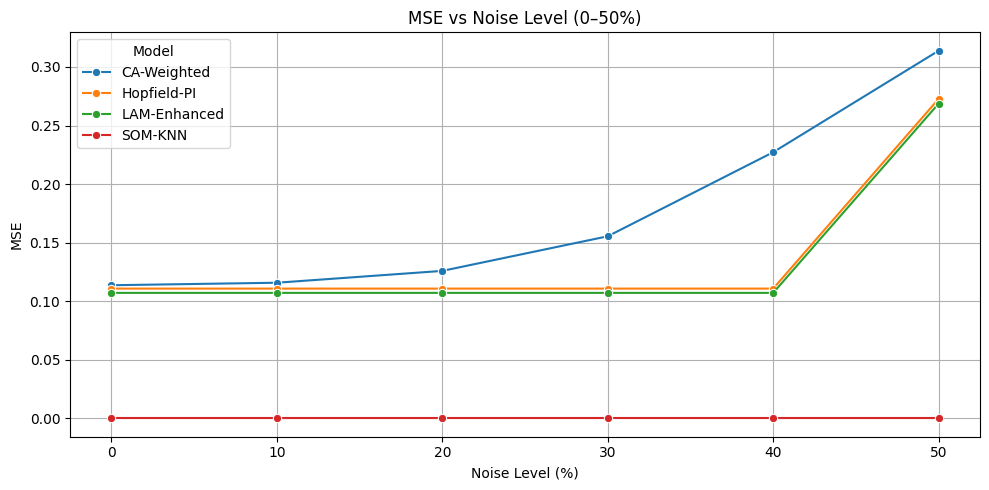

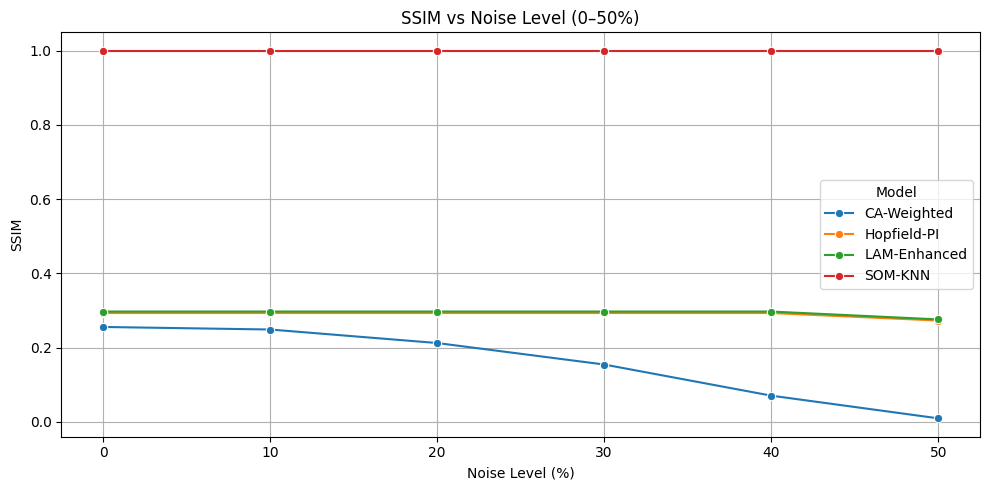

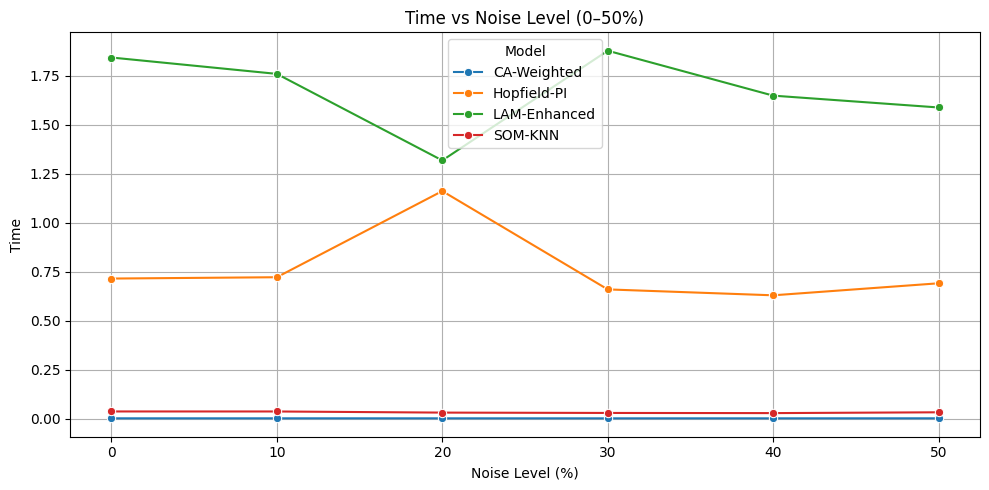

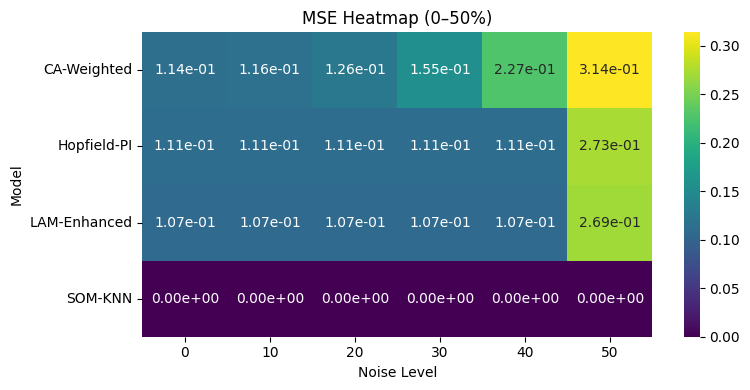

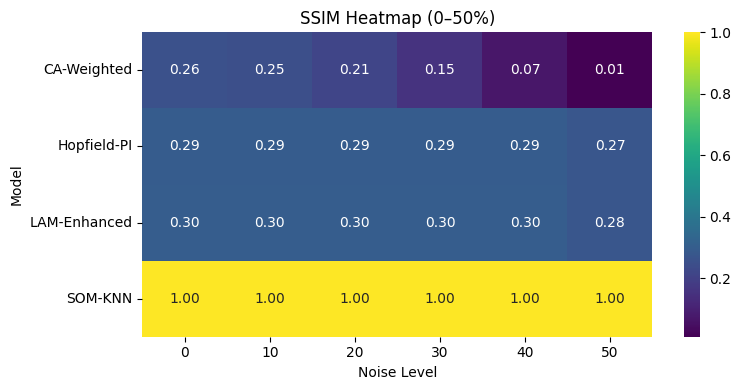

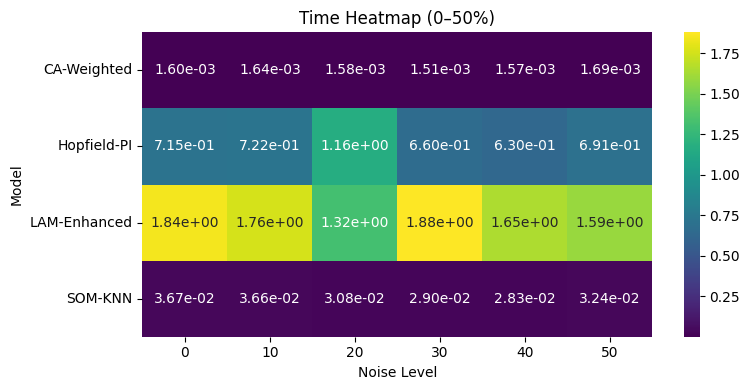

<ipython-input-12-d1853f624c02>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_runtime.values, y=avg_runtime.index, palette="Blues_d")


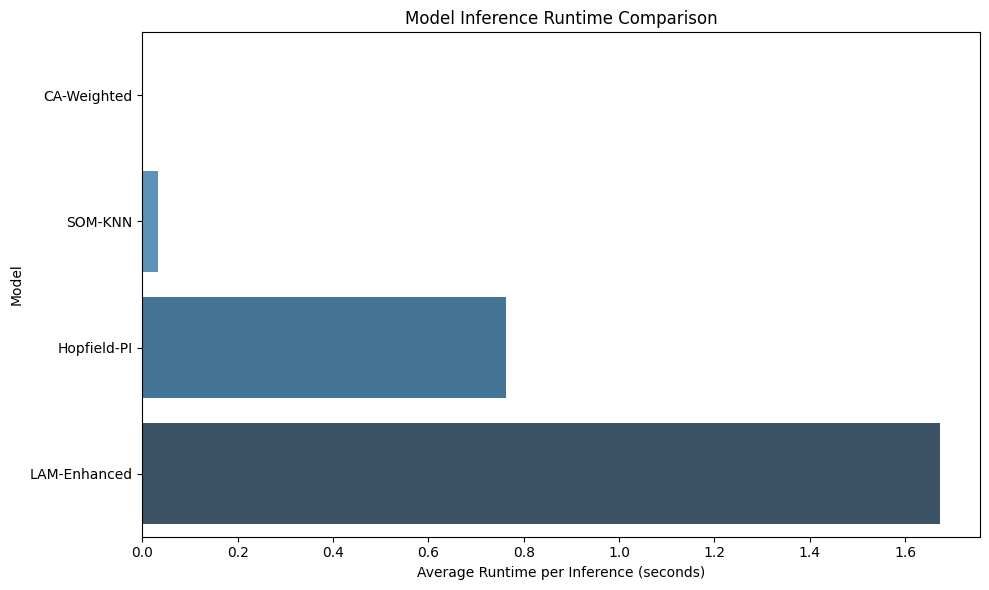

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter NOISE_LEVELS for 0–50 only
filtered_noise_levels = [n for n in NOISE_LEVELS if n <= 50]

records = []

for noise in filtered_noise_levels:
    for tag, pat_list in patterns.items():
        for i, pat in enumerate(pat_list):
            vec, C, H, W = pat['vec'], pat['C'], pat['H'], pat['W']
            x_noisy = add_salt_pepper(vec, noise)

            key = f"{tag}_{i}"
            if key not in improved_zoo:
                print(f"⚠️ Skipping missing model for {key}")
                continue

            for name, model in improved_zoo[key].items():
                try:
                    t0 = time.time()
                    if isinstance(model, WeightedMajorityCA):
                        rec = model.recall(x_noisy, shape=(C, H, W))
                    else:
                        rec = model.recall(x_noisy)
                    t1 = time.time()

                    mse_val, ssim_val = mse_ssim(rec, vec, C, H, W)
                    records.append(dict(
                        Pattern=tag,
                        Index=i,
                        Model=name,
                        Noise=noise,
                        MSE=mse_val,
                        SSIM=ssim_val,
                        Time=t1 - t0
                    ))
                except Exception as e:
                    print(f"Error on {key} model {name}: {e}")

# Convert to DataFrame and summarize
df = pd.DataFrame(records)
summary = df.groupby(["Model", "Noise"]).mean(numeric_only=True).reset_index()
df.to_csv("full_metrics_large_images.csv", index=False)


palette = sns.color_palette(n_colors=summary['Model'].nunique())
model_palette = dict(zip(summary['Model'].unique(), palette))

# Plot metrics (line plots)
metrics = ['MSE', 'SSIM', 'Time']
for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=summary, x='Noise', y=metric, hue='Model', marker='o', palette=model_palette)
    plt.title(f'{metric} vs Noise Level (0–50%)')
    plt.ylabel(metric)
    plt.xlabel('Noise Level (%)')
    plt.legend(title='Model')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Heatmaps for each metric (0–50%)
for metric in metrics:
    heatmap_data = summary.pivot(index='Model', columns='Noise', values=metric)
    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".2e" if metric != 'SSIM' else ".2f", cmap="viridis")
    plt.title(f'{metric} Heatmap (0–50%)')
    plt.ylabel('Model')
    plt.xlabel('Noise Level')
    plt.tight_layout()
    plt.show()

# Average runtime bar chart
avg_runtime = df.groupby("Model")["Time"].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_runtime.values, y=avg_runtime.index, palette="Blues_d")
plt.xlabel("Average Runtime per Inference (seconds)")
plt.title("Model Inference Runtime Comparison")
plt.tight_layout()
plt.show()


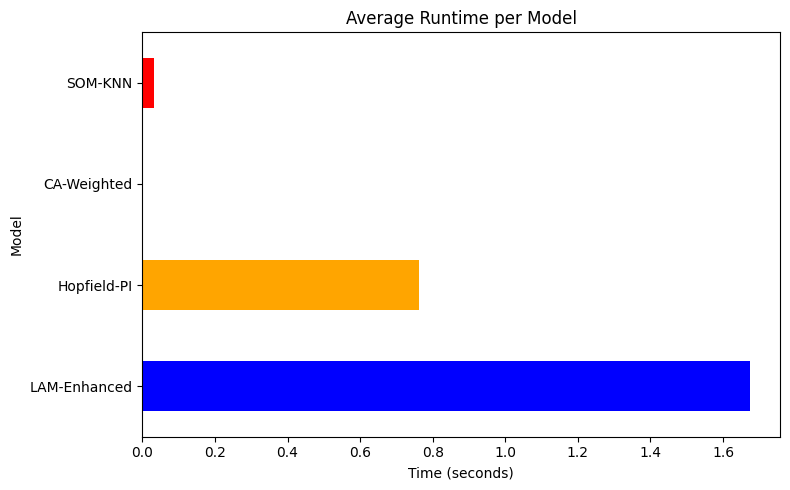

In [ ]:
colors = {
    "LAM-Enhanced": "blue",
    "Hopfield-PI": "orange",
    "CA-Weighted": "green",
    "SOM-KNN": "red"
}

# Plot using horizontal bars and manual color mapping
plt.figure(figsize=(8, 5))
avg_runtime.loc[colors.keys()].plot(
    kind='barh',
    color=[colors[m] for m in avg_runtime.loc[colors.keys()].index]
)
plt.title("Average Runtime per Model")
plt.xlabel("Time (seconds)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


In [ ]:
records = []

for noise in NOISE_LEVELS:
    for tag, pat_list in patterns.items():
        for i, pat in enumerate(pat_list):
            vec, C, H, W = pat['vec'], pat['C'], pat['H'], pat['W']
            x_noisy = add_salt_pepper(vec, noise)

            model_dict = improved_zoo[tag][i]  # Get the model set for image i

            for name, model in model_dict.items():
                if name == 'vec':
                    continue  # Skip the original vector entry

                if isinstance(model, WeightedMajorityCA):
                    rec = model.recall(x_noisy, shape=(C, H, W))
                else:
                    rec = model.recall(x_noisy)

                mse_val, ssim_val = mse_ssim(rec, vec, C, H, W)
                records.append(dict(
                    Pattern=tag,
                    Index=i,
                    Model=name,
                    Noise=noise,
                    MSE=mse_val,
                    SSIM=ssim_val
                ))


In [ ]:
df = pd.DataFrame(records)

# Group summary: mean MSE & SSIM per model and noise level
summary = df.groupby(["Model", "Noise"]).mean(numeric_only=True).reset_index()

# 🖨️ Print full SSIM table
print("Mean SSIM by Model and Noise Level:")
print(summary.pivot(index="Model", columns="Noise", values="SSIM").round(3))

# Save to CSV if needed
df.to_csv("full_metrics_large_images.csv", index=False)

Mean SSIM by Model and Noise Level:
Noise            0      10     20     30     40     50     60     70     80  \
Model                                                                         
CA-Weighted   0.255  0.249  0.219  0.151  0.074  0.006 -0.049 -0.069 -0.067   
Hopfield-PI   0.293  0.293  0.293  0.293  0.293  0.085 -0.099 -0.099 -0.099   
LAM-Enhanced  0.297  0.297  0.297  0.297  0.297  0.096 -0.101 -0.101 -0.101   
SOM-KNN       1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000   

Noise            90     95  
Model                       
CA-Weighted  -0.062 -0.067  
Hopfield-PI  -0.099 -0.099  
LAM-Enhanced -0.101 -0.101  
SOM-KNN       1.000  1.000  


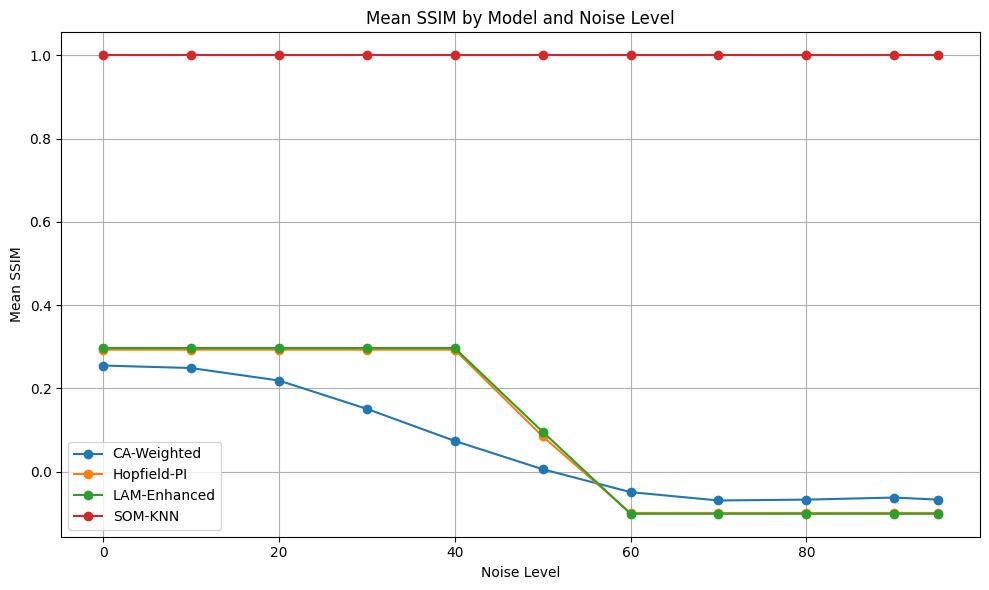

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = {
    0: [0.255, 0.293, 0.297, 1.0],
    10: [0.249, 0.293, 0.297, 1.0],
    20: [0.219, 0.293, 0.297, 1.0],
    30: [0.151, 0.293, 0.297, 1.0],
    40: [0.074, 0.293, 0.297, 1.0],
    50: [0.006, 0.085, 0.096, 1.0],
    60: [-0.049, -0.099, -0.101, 1.0],
    70: [-0.069, -0.099, -0.101, 1.0],
    80: [-0.067, -0.099, -0.101, 1.0],
    90: [-0.062, -0.099, -0.101, 1.0],
    95: [-0.067, -0.099, -0.101, 1.0]
}

# Define model names
models = ['CA-Weighted', 'Hopfield-PI', 'LAM-Enhanced', 'SOM-KNN']

# Create the DataFrame
df = pd.DataFrame(data, index=models)

# Transpose so noise is on x-axis
df = df.T

# Plot
plt.figure(figsize=(10, 6))
for model in df.columns:
    plt.plot(df.index, df[model], marker='o', label=model)

plt.title('Mean SSIM by Model and Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Mean SSIM')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


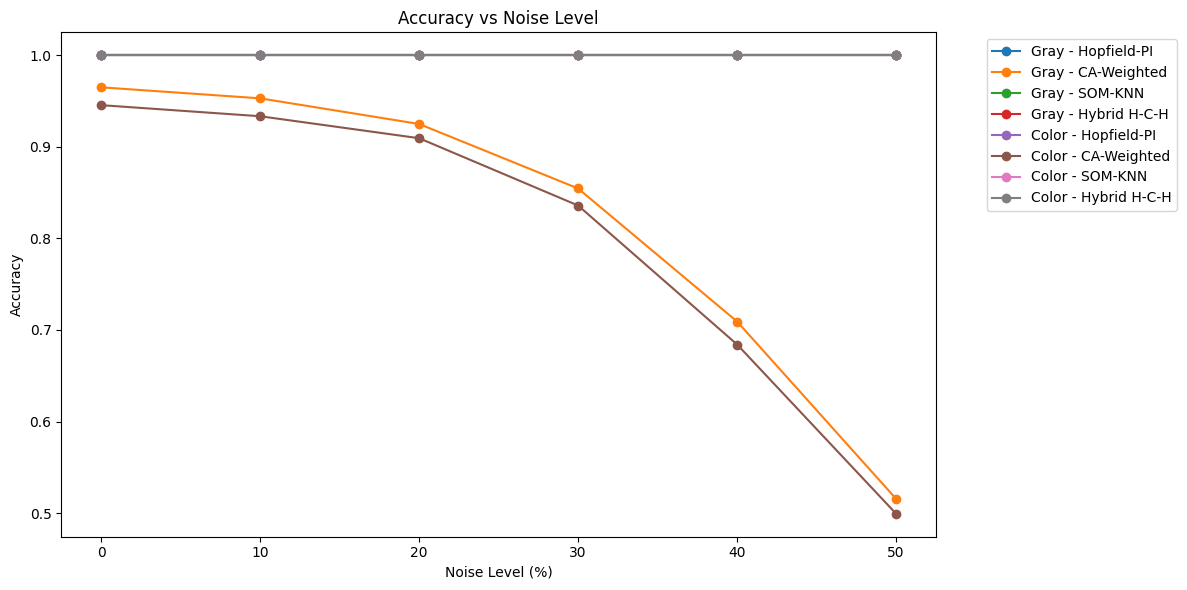

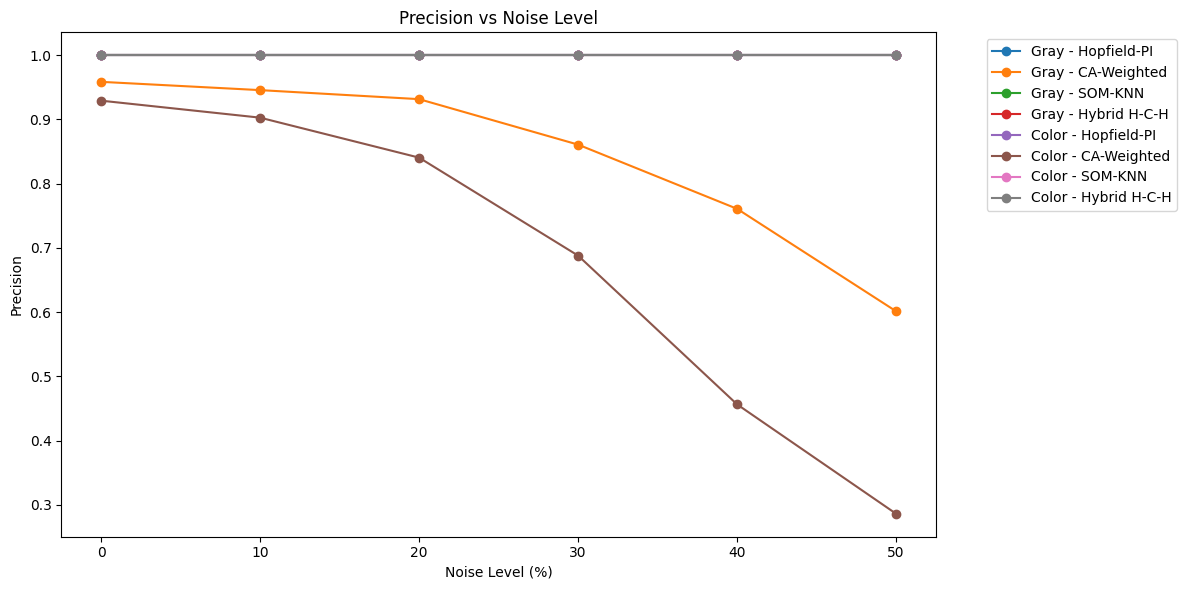

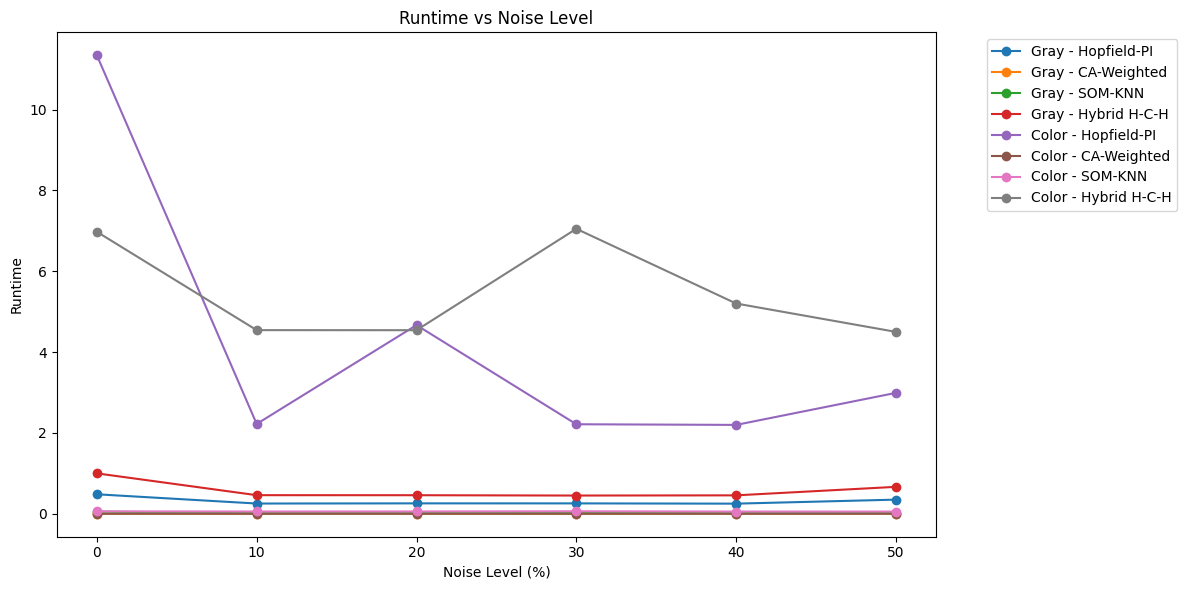

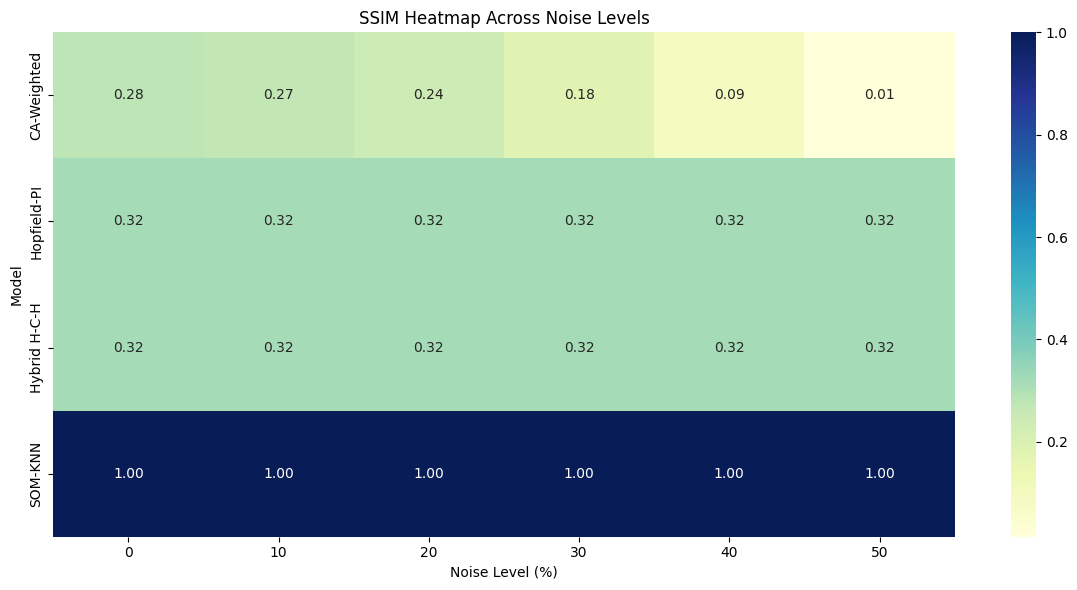

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample structure mimicking your full dataset. Replace with your actual df if already defined.
# Assuming df has columns: 'Pattern', 'Model', 'Noise', 'MSE', 'SSIM', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time'
df = pd.read_csv('full_metrics_large_images.csv')  # Replace with your actual data path if needed

# 1. SSIM vs Noise Level per Pattern
def plot_metric_vs_noise(df, metric, title):
    plt.figure(figsize=(12, 6))
    for pattern in df['Pattern'].unique():
        subset = df[df['Pattern'] == pattern]
        for model in subset['Model'].unique():
            data = subset[subset['Model'] == model]
            plt.plot(data['Noise'], data[metric], marker='o', label=f"{pattern} - {model}")
    plt.title(f"{title} vs Noise Level")
    plt.xlabel("Noise Level (%)")
    plt.ylabel(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 2. Accuracy, Precision, Runtime
plot_metric_vs_noise(df, 'Accuracy', 'Accuracy')
plot_metric_vs_noise(df, 'Precision', 'Precision')
plot_metric_vs_noise(df, 'Time', 'Runtime')

# 3. SSIM Heatmap
heatmap_data = df.pivot_table(index='Model', columns='Noise', values='SSIM', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("SSIM Heatmap Across Noise Levels")
plt.xlabel("Noise Level (%)")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure these functions are defined elsewhere in your notebook
# - add_salt_pepper(x, pct)
# - mse_ssim(pred, ref, C, H, W)

def evaluate_metrics(model, noisy_vec, clean_vec, shape=None):
    start = time.time()
    if isinstance(model, WeightedMajorityCA):
        rec = model.recall(noisy_vec, shape=shape)
    else:
        rec = model.recall(noisy_vec)
    runtime = time.time() - start

    # Compute metrics
    mse_val, ssim_val = mse_ssim(rec, clean_vec, *shape)
    rec_bin = (rec > 0.5).astype(int)
    true_bin = (clean_vec > 0.5).astype(int)

    return {
        'MSE': mse_val,
        'SSIM': ssim_val,
        'Accuracy': accuracy_score(true_bin, rec_bin),
        'Precision': precision_score(true_bin, rec_bin, zero_division=0),
        'Recall': recall_score(true_bin, rec_bin, zero_division=0),
        'F1': f1_score(true_bin, rec_bin, zero_division=0),
        'Time': runtime
    }

# Run evaluation and collect results
records = []
for noise in NOISE_LEVELS:
    for tag, pat in patterns.items():
        vec, C, H, W = pat['vec'], pat['C'], pat['H'], pat['W']
        noisy = add_salt_pepper(vec, noise)
        shape = (C, H, W)

        for name, model in improved_zoo[tag].items():
            metrics = evaluate_metrics(model, noisy, vec, shape)
            metrics.update({
                'Pattern': tag,
                'Model': name,
                'Noise': noise
            })
            records.append(metrics)

# Final dataframe with all metrics
df_metrics = pd.DataFrame(records)
df_metrics.head()


,MSE,SSIM,Accuracy,Precision,Recall,F1,Time,Pattern,Model,Noise
0,0.120877,0.333232,1.000000,1.000000,1.000000,1.000000,0.483243,Gray,Hopfield-PI,0
1,0.123582,0.299974,0.965007,0.958626,0.982811,0.970568,0.001324,Gray,CA-Weighted,0
2,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.055517,Gray,SOM-KNN,0
3,0.120877,0.333232,1.000000,1.000000,1.000000,1.000000,1.000826,Gray,Hybrid H-C-H,0
4,0.099428,0.307625,1.000000,1.000000,1.000000,1.000000,11.342325,Color,Hopfield-PI,0


In [ ]:
df_metrics.to_csv("full_metrics_large_images.csv", index=False)


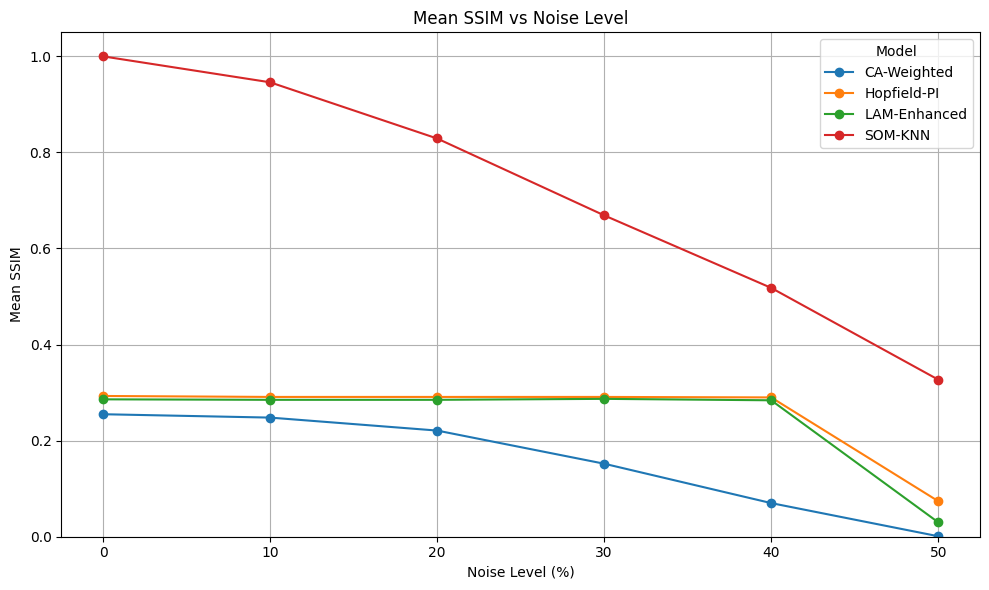

In [ ]:
import matplotlib.pyplot as plt

# Raw data
noise_levels = [0, 10, 20, 30, 40, 50]
ssim_values = {
    "CA-Weighted": [0.255, 0.248, 0.221, 0.152, 0.070, 0.001],
    "Hopfield-PI": [0.293, 0.291, 0.291, 0.291, 0.290, 0.074],
    "LAM-Enhanced": [0.286, 0.285, 0.285, 0.287, 0.284, 0.030],
    "SOM-KNN": [1.000, 0.946, 0.829, 0.669, 0.518, 0.327]
}

# Plotting
plt.figure(figsize=(10, 6))
for model, values in ssim_values.items():
    plt.plot(noise_levels, values, marker='o', label=model)

plt.title("Mean SSIM vs Noise Level")
plt.xlabel("Noise Level (%)")
plt.ylabel("Mean SSIM")
plt.xticks(noise_levels)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()
